# Предсказание акций компнании Tesla по данным о закрытии
### Выбрал для использования модель с долгой краткосрочной памятью - LSTM

In [1]:
import datetime
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor


plt.style.use('fivethirtyeight')
df = pd.read_csv('../data/TSLA.csv')

<Axes: xlabel='Date'>

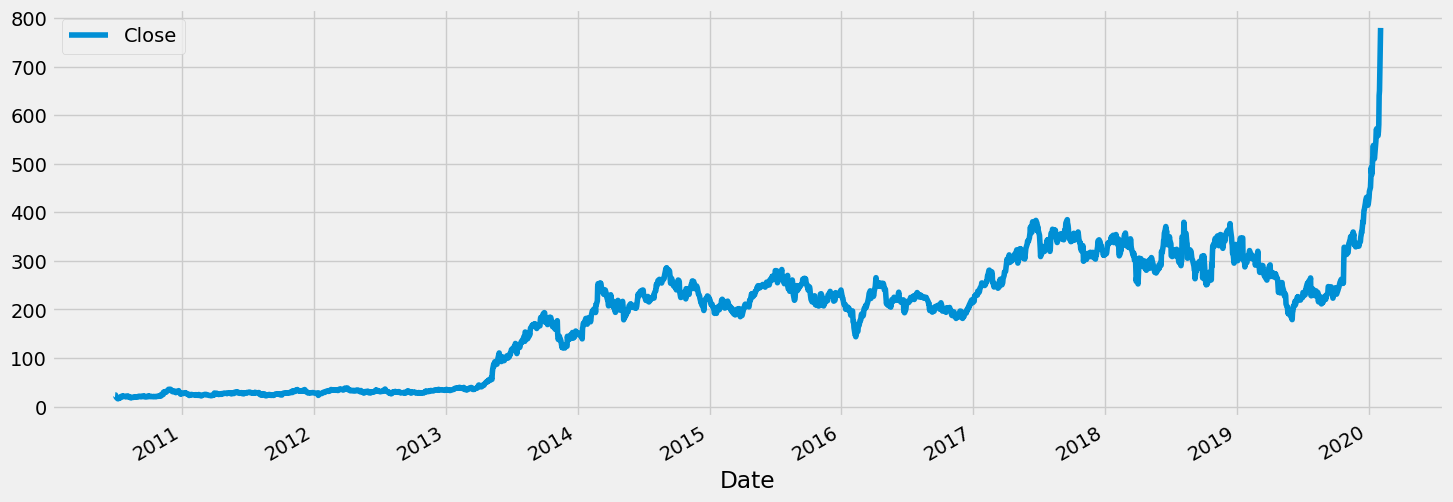

In [2]:
# Не стационарный график цены закрытия
tesla = df.copy()
tesla["Date"] = pd.to_datetime(df["Date"], format = '%Y-%m-%d')
tesla = tesla.set_index('Date')
tesla[["Close"]].plot(figsize=(16,6))

In [3]:
# Нам не нужны даты
df = df.drop(['Date'],axis=1)
df.head()

,Open,High,Low,Close,Adj Close,Volume
0,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,20.000000,20.00,15.830000,16.110001,16.110001,6866900


Мы хотим предсказывать цену закрытия, поэтому фичами можем сделать
* цену открытия
* наивысшую цену за день
* наименьшую цену за день
* volume

In [4]:
X, y = df[["Open", "High", "Low", "Volume"]], df["Close"]

# Делим на датасеты
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# инициализируем модель и обучаем
scikit_model = LinearRegression()
scikit_model.fit(X_train, y_train)

LinearRegression()

In [6]:
# Посмотрим метрику 
scikit_score = scikit_model.score(X_test, y_test)
scikit_score

0.9997117604197412

In [7]:
# Таблица с предиктами
scikit_predictions = scikit_model.predict(X_test)

comparison = pd.DataFrame({'y_test': y_test, 'scikit_predictions': scikit_predictions})
comparison.head()

,y_test,scikit_predictions
410,31.490000,31.442062
199,24.650000,24.529889
1670,279.760010,278.905101
1934,328.200012,330.673522
1036,259.320007,262.081422


### Посмотрм что будет, если обучить через catboost

In [ ]:
# Создание модели CatBoostRegressor
catboost_model = CatBoostRegressor()

# Определение гиперпараметров и их значений для подбора
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'iterations': [100, 200, 300]
}

# Подбор гиперпараметров с использованием GridSearchCV
grid_search = GridSearchCV(catboost_model, param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Вывод наилучших параметров и значения метрик
print("Наилучшие параметры: ", grid_search.best_params_)
catboost_score = np.sqrt(grid_search.score(X_test, y_test))
print("Наилучшее значение RMSE на тестовом наборе: ", catboost_score)

In [9]:
print(f"scikit_score = {scikit_score}")
print(f"catboost_score = {catboost_score}")

scikit_score = 0.9997117604197412
catboost_score = 0.9941082821120957


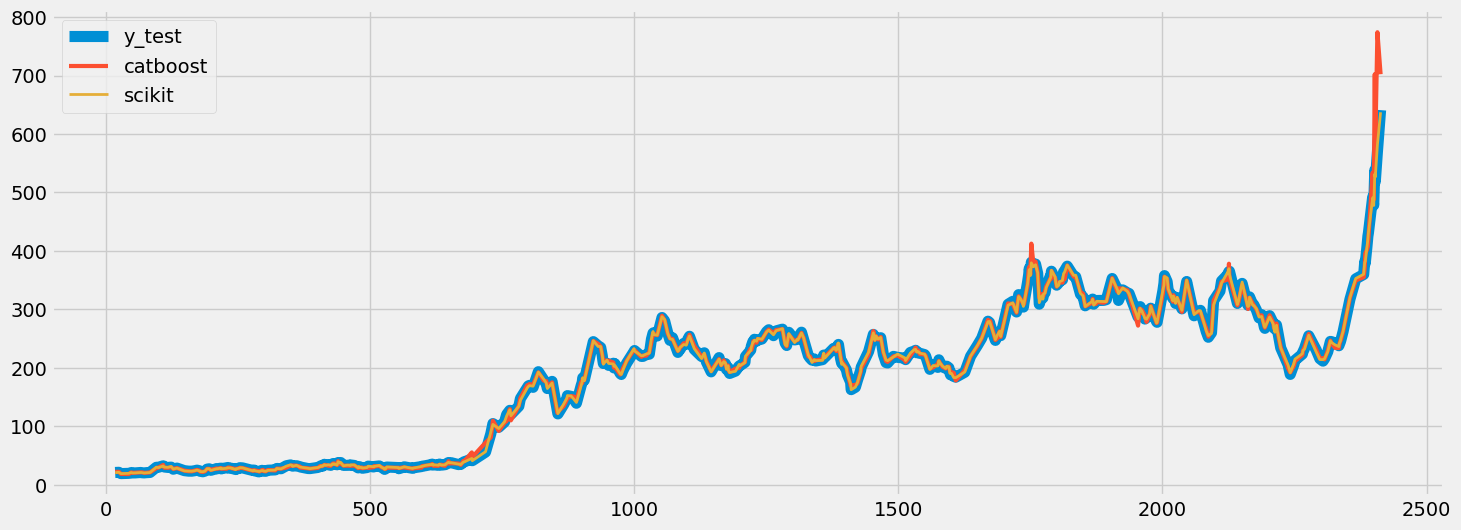

In [10]:
# Визуализируем
comparison = comparison.sort_index(ascending=True)

comparison["catboost_predictions"] = grid_search.predict(X_test.sort_index(ascending=True))

fig, ax = plt.subplots()

ax.plot(comparison[["y_test"]], label="y_test", linewidth=8)
ax.plot(comparison[["catboost_predictions"]], label="catboost", linewidth=3)
ax.plot(comparison[["scikit_predictions"]], label="scikit", linewidth=2)

fig.set_figheight(6)
fig.set_figwidth(16)
ax.legend()
plt.show()

In [11]:
comparison

,y_test,scikit_predictions,catboost_predictions
18,20.950001,20.547389,21.949187
25,21.260000,21.281319,22.135775
29,19.030001,18.954251,18.432687
44,19.480000,19.483042,18.267986
48,20.540001,20.828693,21.031769
...,...,...,...
2400,478.149994,477.699471,487.808860
2402,537.919983,531.383638,702.247054
2403,518.500000,526.471386,584.338626
2407,569.559998,581.575604,774.052637
